# Практическое ДЗ 1. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [ ]:
!pip install -q moviepy --upgrade

In [1]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
video.fps

23.976023976023978

In [4]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


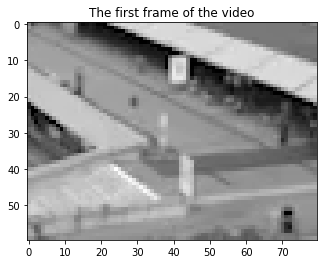

In [5]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

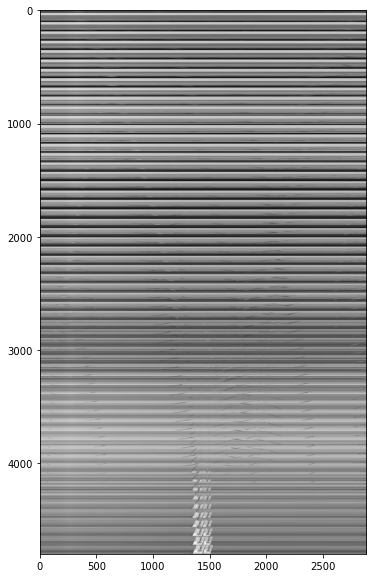

In [6]:
nframes, size_w, size_h = arr.shape

M = arr.reshape((nframes, size_h * size_w)).T
plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

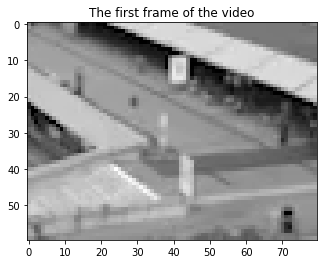

In [7]:
first_frame = M[:,0].reshape(size_w , size_h)
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

In [8]:
U, Sigma, V = np.linalg.svd(M, full_matrices=False)
V = V.T
Sigma

array([4.86153209e+05, 1.46361630e+04, 5.23807264e+03, ...,
       4.85504631e-11, 2.41638492e-12, 5.92188311e-13])

In [9]:
divised_sigma = Sigma / Sigma[0]
num = np.arange(0, divised_sigma.size, 1)

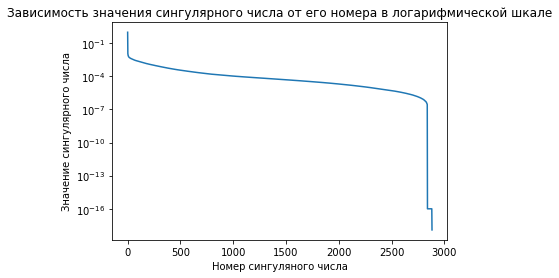

In [13]:
plt.figure()
plt.semilogy(num, divised_sigma )
plt.xlabel('Номер сингуляного числа')
plt.ylabel('Значение сингулярного числа')
plt.title('Зависимость значения сингулярного числа от его номера в логарифмической шкале')
plt.show()

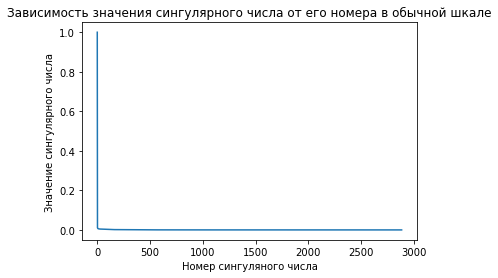

In [12]:
plt.figure()
plt.plot(num, divised_sigma )
plt.xlabel('Номер сингуляного числа')
plt.ylabel('Значение сингулярного числа')
plt.title('Зависимость значения сингулярного числа от его номера в обычной шкале')
plt.show()

Наибольшие несколько значений отвечают за фон, а несколько наименьших отвечают за движущиеся предметы, поэтому они так сильно выделяются

3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в матричной 2-норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

In [14]:
def trunc_svd(M, r):
    U, Sigma, V = np.linalg.svd(M, full_matrices=False)                              
    cropped_Sigma = np.diag(Sigma[:r])
    cropped_U = U[:, :r]
    cropped_V = V[:r, :]
    Mr = np.dot(np.dot(cropped_U, cropped_Sigma),cropped_V)
    
    rnk = np.linalg.matrix_rank(M)
    if (r > rnk):
        return
    
    numenator = (np.dot(Sigma[r:rnk].T, Sigma[r:rnk])) ** 1/2
    denominator = np.dot(Sigma.T, Sigma) ** 1/2
    
    rel_eps = numenator / denominator
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            
        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    return (Mr, rel_eps)

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [15]:
(M_svd, rel_eps) = trunc_svd(M, 1)

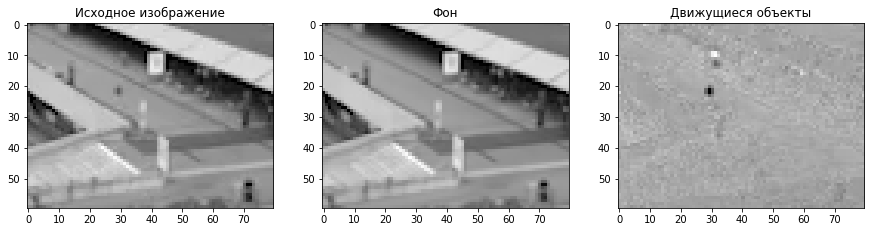

In [16]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M[:,0].reshape(size_w , size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(M_svd[:,0].reshape(size_w , size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(M[:,0].reshape(size_w , size_h) - M_svd[:,0].reshape(size_w , size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [17]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 100 x 178, 
number of frames: 3600


In [18]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = arr3.reshape((nframes, size_h * size_w)).T

image size: 100 x 178, 
number of frames: 3600


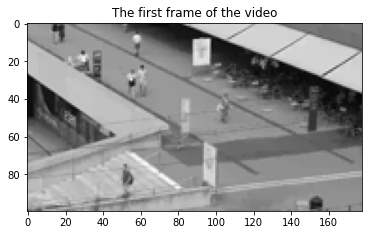

In [19]:
first_frame = M3[:,0].reshape(size_w , size_h)
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [20]:
def rand_svd(M, r, oversampling=10):
    Sigma_full = np.random.rand(M[0].shape[0], r + oversampling)
    
    Y = M @ Sigma_full
    
    Q, R = np.linalg.qr(Y)
    W, Sigma_cropped, V = np.linalg.svd(Q.T @ M, full_matrices=False)
    
    Sigma_cropped = np.diag(Sigma_cropped[:r])
    U = Q @ W
    U_cropped = U[:, :r]
    V_cropped = V[:r, :]
    Mr = np.dot(np.dot(U_cropped, Sigma_cropped),V_cropped)
    
    numenator = np.linalg.norm(M - Mr)
    denominator = np.linalg.norm(M)
    rel_eps = numenator / denominator
    
    
    return (Mr, rel_eps)
    
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''


2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [21]:
(M_svd_rand, rel_eps_rand) = rand_svd(M3, 1, 10)

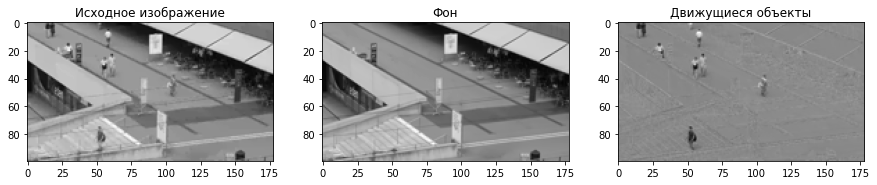

In [22]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M3[:,0].reshape(size_w , size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(M_svd_rand[:,0].reshape(size_w , size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(M3[:,0].reshape(size_w , size_h) - M_svd_rand[:,0].reshape(size_w , size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

In [23]:
epses = [0] * 15 
cnt = 0
for p in range(0, 30, 2):
    for i in range(10):
        (M_svd_rand, rel_eps_rand) = rand_svd(M3, 2, p)
        epses[cnt] += rel_eps_rand
    epses[cnt] /= 10
    cnt += 1

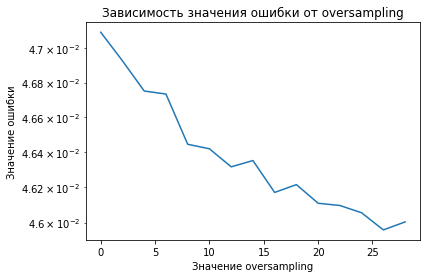

In [24]:
num = np.arange(0, 30, 2)
plt.semilogy(num, epses)
plt.xlabel('Значение oversampling')
plt.ylabel('Значение ошибки')
plt.title('Зависимость значения ошибки от oversampling')
plt.show()

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти. 

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [25]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [26]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [27]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

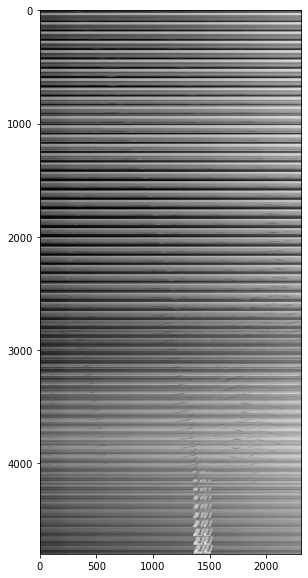

In [28]:
nframes2, size_w, size_h = arr2.shape
M2 = arr2.reshape((nframes2, size_h * size_w)).T

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [29]:
import time

In [30]:
st = time.time()
(M2_svd, eps_svd) = trunc_svd(M2, 2)
fin = time.time()
working_time = fin - st
working_time


12.274763107299805

In [31]:
st = time.time()
(M2_rand, eps_rand) = rand_svd(M2, 2)
fin = time.time()
working_time = fin - st
working_time

0.07469511032104492

Как можно увидеть, рандомизированный алгоритм работает сильно быстрее, что подверждает утверждение с лекции

3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [32]:
(M_svd_rand, rel_eps_rand) = rand_svd(M3, 2)
(M_svd, rel_eps) = trunc_svd(M3, 2)

In [33]:
print('Ошибка библиотечного svd с переменным освещением', eps_svd)
print('Ошибка рандомного svd с переменным освещением', eps_rand)
print('Ошибка библиотечного svd с постоянным освещением', rel_eps)
print('Ошибка рандомного svd с постоянным освещением', rel_eps_rand)

Ошибка библиотечного svd с переменным освещением 0.0036762795606145337
Ошибка рандомного svd с переменным освещением 0.06219054043100992
Ошибка библиотечного svd с постоянным освещением 0.002075134955964959
Ошибка рандомного svd с постоянным освещением 0.04624130987950147


Как можно увидеть, рандомное svd хоть работает быстрее, выдает большую ошибку, так же понятно, что svd приближение справляется лучше в условиях постоянного освещения. Что также подтверждает утверждение с лекции

4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [34]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr =np.array([(M.T)[i, :].reshape(size_w, size_h) for i in range(nframes)])
     
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [35]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным. 

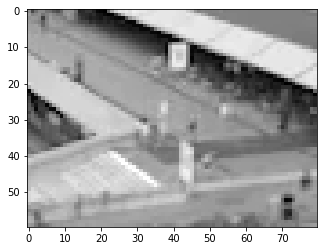

In [36]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [37]:
U, S, VT = np.linalg.svd(M2, full_matrices=False)   
U_2 = U[:, :2]
S_2= S[:2]
VT_2 = VT[:, :2]

In [38]:
def project_new_frames(U, S, VT, new_frames):
    projection = U @ U.T @ new_frames
    return projection
    
    
    '''
        Input
            U, S, VT: rank r compact SVD of matrix M2 (U @ S @ VT = M2_r)
            new_frames:  vector (size_h * size_w,) or matrix (size_h * size_w x nframes)

        Output
            proj: projection of new frames to Im(M2_r)
    '''

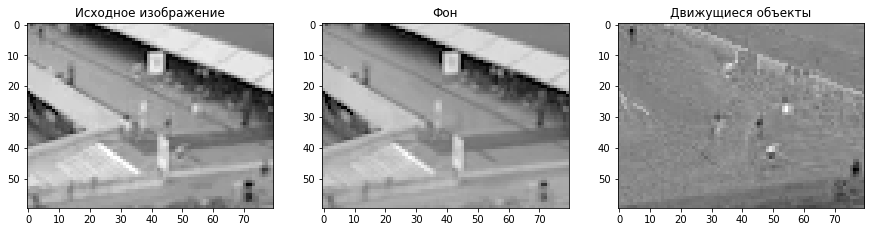

In [39]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj.reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(new_frame.reshape(size_w, size_h) - new_frame_proj.reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [41]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = remaining.reshape((remaining_nframes, size_h * size_w)).T
M_full = np.concatenate((M2, M_remaining), axis = 1)

In [42]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [43]:
r = 2
oversampling = 10


Sigma_full = np.random.rand(M[0].shape[0], r + oversampling)
    
Y = M @ Sigma_full

Q, R = np.linalg.qr(Y)
W, Sigma_cropped, V = np.linalg.svd(Q.T @ M, full_matrices=False)
    
S_2_rand = np.diag(Sigma_cropped[:r])
U = Q @ W
U_2_rand = U[:, :r]
VT_2_rand = V[:r, :]

In [44]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad 
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [45]:
M_true = trunc_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [46]:
def cnt_eps(M, Mr):
    numenator = np.linalg.norm(M - Mr)
    denominator = np.linalg.norm(M)
    rel_eps = numenator / denominator
    return rel_eps

In [47]:
eps_stand = cnt_eps(M_true, M_proj)
eps_rand = cnt_eps(M_true, M_proj_rand)
print('Ошибка при использовании стандратного sdv', eps_stand)
print('Ошибка при использовании рандомизированного sdv', eps_rand)

Ошибка при использовании стандратного sdv 0.02000144506567803
Ошибка при использовании рандомизированного sdv 0.06644094749993583


**Выводы:**

Как мы видим, качество видео со страндартным алгоритмом несколько лучше, чем с рандомизированным, поскольку для стандартного разложения ошибка приближения у этого алгоритма меньше

### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [48]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

--2023-02-08 19:29:46--  https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3105 (3,0K) [text/plain]
Saving to: ‘r_pca.py.1’

r_pca.py.1          100%[===================>]   3,03K  --.-KB/s    in 0s      

2023-02-08 19:29:46 (15,0 MB/s) - ‘r_pca.py.1’ saved [3105/3105]



Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

iteration: 1, error: 10.068199117428186
iteration: 100, error: 0.7004423976769881
iteration: 200, error: 0.42632079958290864
iteration: 300, error: 0.2861554334232198
iteration: 400, error: 0.19763762992219236
iteration: 500, error: 0.14919451305965872
iteration: 600, error: 0.1197776098484241
iteration: 700, error: 0.10258379675947936
iteration: 800, error: 0.08740324618530546
iteration: 900, error: 0.07772202053817785
iteration: 1000, error: 0.06319242183755182
iteration: 1100, error: 0.05727756160939069
iteration: 1200, error: 0.04361963207363383
iteration: 1300, error: 0.042779182959189185
iteration: 1400, error: 0.02831336360999501
iteration: 1500, error: 0.028215592053768723
iteration: 1546, error: 0.017703452811066063
(4800, 360)
(4800, 360)


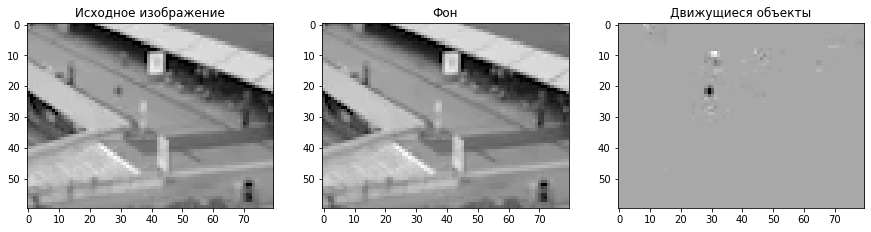

In [49]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)
print(L.shape)
print(S.shape)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(Mt[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(L[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(S[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [50]:
video_rpca = M_to_video(S, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

In [51]:
def randomized_subspace_iteration(M, r, q , oversampling = 10):
    Sigma_full = np.random.rand(M[0].shape[0], r + oversampling)
    Y = M @ Sigma_full
    Q, R = np.linalg.qr(Y)
    for j in range(0, q):
        Y_new = M.T @ Q
        Q_new, R_new = np.linalg.qr(Y_new)
        Y = M @ Q_new
        Q, R = np.linalg.qr(Y)
    return Q

In [54]:
def get_result(M, r, q):
    Q = randomized_subspace_iteration(M, r, q)
    W, Sigma_cropped, V = np.linalg.svd(Q.T @ M, full_matrices=False)
    
    Sigma_cropped = np.diag(Sigma_cropped[:r])
    U = Q @ W
    U_cropped = U[:, :r]
    V_cropped = V[:r, :]
    Mr = np.dot(np.dot(U_cropped, Sigma_cropped),V_cropped)
    return Mr
    

In [55]:
Mr = get_result(M, 5, 20) #для ранга 5, возьмем q 20
video_rpca = M_to_video(Mr, 20, size_w, size_h)
video_rpca.ipython_display(width=300, maxduration=250, fps=20)


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [56]:
Mr = get_result(M, 20, 20) #для ранга 20, возьмем q 20
video_rpca = M_to_video(Mr, 20, size_w, size_h)
video_rpca.ipython_display(width=300, maxduration=250, fps=20)


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [57]:
Mr = get_result(M, 50, 20) #для ранга 50, возьмем q 20
video_rpca = M_to_video(Mr, 20, size_w, size_h)
video_rpca.ipython_display(width=300, maxduration=250, fps=20)


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Будем менять количество итераций, то есть q от 1 до 100 с шагом 2

In [58]:
def get_norm(M, r):
    M_true = trunc_svd(M, r)[0]
    norm = []
    for i in range(1, 100, 2):
        Mr = get_result(M, r,i)
        norm.append(np.linalg.norm(M_true - Mr))
    return norm
    

In [59]:
norm5 = get_norm(M, 5)

In [60]:
norm20 = get_norm(M, 20)


In [61]:
norm50 = get_norm(M, 50)

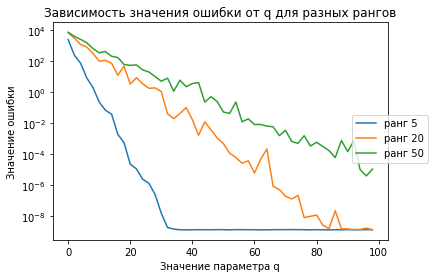

In [62]:
fig = plt.figure()
plt.semilogy(np.arange(0, 100, 2), norm5, np.arange(0, 100, 2), norm20, np.arange(0, 100, 2), norm50)
plt.xlabel('Значение параметра q')
plt.ylabel('Значение ошибки')
fig.legend(['ранг 5','ранг 20','ранг 50'], loc = 'center right')
plt.title('Зависимость значения ошибки от q для разных рангов')
plt.show()